# 미니 프로젝트 : 가위바위보 분류기를 만들자  

## 첫 시도  
cloud 환경이 아닌 local(m1 맥북) 환경에서 테이스 한 결과임을 참고 바란다.

### 데이터 만들기  

가위, 바위, 보 손모양을 촬영한 이미지를 각각 100장씩 만들어 모델을 학습시켜보았다.  
이미지는 구글의 [Teachable Machine](https://teachablemachine.withgoogle.com/) 사이트를 통해 쉽게 만들 수 있었다.  
이미지는 size는 224x224 이므로 MNIST와 동일한 28x28 사이즈로 변경하여 사용하였다.


### 이미지 사이즈 변경   
resize 하기 위한 PIL library load

In [1]:
from PIL import Image
import os
import glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


가위, 바위, 보 이미지를 28x28로 resize 한다.

In [2]:
def resize_images(img_path):
    
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장
    target_size=(28,28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

# 가위, 바위, 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/scissor"  #가위 경로
rock_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/rock"        #바위 경로
paper_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/paper"      #보  경로

resize_images(scissor_image_dir_path)  # 가위 resize
print("가위 이미지 resize 완료!", '\n')
resize_images(rock_image_dir_path)     # 바위 resize
print("바위 이미지 resize 완료!", '\n')
resize_images(paper_image_dir_path)    # 보 resize
print("보 이미지 resize 완료!", '\n')


100  images to be resized.
100  images resized.
가위 이미지 resize 완료! 

100  images to be resized.
100  images resized.
바위 이미지 resize 완료! 

100  images to be resized.
100  images resized.
보 이미지 resize 완료! 



숫자 손글씨 이미지 분류기는 `mnist.load_data()` 라는 함수로 데이터를 불러왔다.  
가위, 바위, 보 이미지 데이터를 불러오는 load_data() 함수를 만들자.

가위바위보의 경우 3개의 클래스 즉, ***가위: 0, 바위: 1, 보: 2*** 로 라벨링 하였다.

In [3]:
import numpy as np

def load_data(img_path, number_of_data=300):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


`load_data()` 함수를 통해 이미지 데이터를 불러오자.

In [4]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

print("x_train_norm shape: {}".format(x_train_norm.shape))

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)
x_train_norm shape: (300, 28, 28, 3)


위와 같이 입력값인 x_train 데이터는 `(데이터개수, 이미지 크기 x, 이미지 크기 y, 채널수)` 형태로 생성되고  
*컬러 이미지이기 때문에 R, G, B 값으로 표현되어 3개의 채널수를 가진다*

이미지를 확인해 보자.

라벨:  0


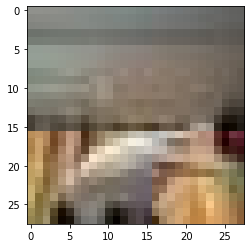

In [5]:
import matplotlib.pyplot as plt

plt.imshow(x_train[0])
print('라벨: ', y_train[0])

### 딥러닝 네크워크 설계



데이터의 준비가 끝났으니 가위, 바위, 보를 인식하는 딥러닝 네트워크를 설계해 보자.

In [6]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)   # Tensorflow의 버전을 출력

Init Plugin
Init Graph Optimizer
Init Kernel
2.5.0


In [7]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB

Model에 추가된 Layer 개수:  7


2022-01-09 18:30:28.877222: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-09 18:30:28.877450: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


딥러닝 네트워크 모델을 확인해 보자.

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 9

### 딥러닝 네트워크 학습시키기  
x_train 학습 데이터로 딥러닝 네트워크를 학습시켜 보자.

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

2022-01-09 18:30:51.265237: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-09 18:30:51.265410: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-09 18:30:51.369439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10
10/10 [==============================] - 0s 11ms/step - loss: 1.0833 - accuracy: 0.3400
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 1.0124 - accuracy: 0.5367
Epoch 3/10
10/10 [==============================] - 0s 7ms/step - loss: 0.9036 - accuracy: 0.8100
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 0.7267 - accuracy: 0.8467
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.5556 - accuracy: 0.8767
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.4341 - accuracy: 0.8867
Epoch 7/10
10/10 [==============================] - 0s 8ms/step - loss: 0.3402 - accuracy: 0.9300
Epoch 8/10
10/10 [==============================] - 0s 8ms/step - loss: 0.2383 - accuracy: 0.9500
Epoch 9/10
10/10 [==============================] - 0s 9ms/step - loss: 0.2214 - accuracy: 0.9233
Epoch 10/10
10/10 [==============================] - 0s 8ms/step - loss: 0.2141 - accuracy: 0.9333


### 모델 성능 평가  
다른 사람의 가위, 바위, 보 이미지 각 50장(합 150장)을 이용하여 모델의 성능을 평가해 본다.  
학습용 이미지와 같이 시험용 이미지도 size 28x28 로 resize 한다.  

In [10]:
test_scissor_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/test/scissor"
resize_images(test_scissor_image_dir_path)   # 테스트 가위 이미지 resize
print("테스트용 가위 이미지 resize 완료!", '\n')

test_rock_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/test/rock"
resize_images(test_rock_image_dir_path)   # 테스트 바위 이미지 resize
print("테스트용 위 이미지 resize 완료!", '\n')

test_paper_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/test/paper"
resize_images(test_paper_image_dir_path)   # 테스트 보 이미지 resize
print("테스트용 보 이미지 resize 완료!", '\n')

50  images to be resized.
50  images resized.
테스트용 가위 이미지 resize 완료! 

50  images to be resized.
50  images resized.
테스트용 위 이미지 resize 완료! 

50  images to be resized.
50  images resized.
테스트용 보 이미지 resize 완료! 



`load_data()` 함수를 재활용하여 테스트용 이미지를 확인해 보자.

In [11]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_28x28_300/test"
(x_test, y_test)=load_data(image_dir_path, 150)

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

학습데이터(x_train)의 이미지 개수는 150 입니다.
x_test shape: (150, 28, 28, 3)
y_test shape: (150,)


테스트용 데이터가 준비되었으니 훈련시킨 model을 사용하여 test_accuracy를 측정해 보았다.

In [12]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

5/5 - 0s - loss: 839.3958 - accuracy: 0.3333
test_loss : 839.3958129882812
test_accuracy : 0.3333333432674408


2022-01-09 18:31:16.426564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


성능 평가를 한 결과가 **약 33%** 나왔다.
그냥 생각해도 일반적인 확률로 나온 것으로 보인다.

그럼 잘못 예측된 데이터들을 한번 자세히 살펴보자.


In [13]:
predicted_result = model.predict(x_test)  
predicted_labels = np.argmax(predicted_result, axis=1)

2022-01-09 18:31:39.095727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


예측확률분포: [0. 0. 1.]
라벨: 0, 예측결과: 2


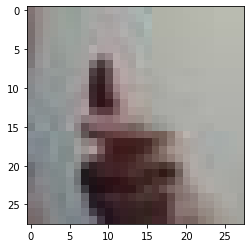

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


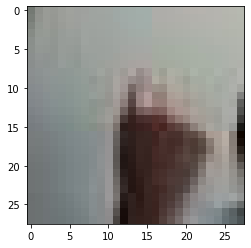

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


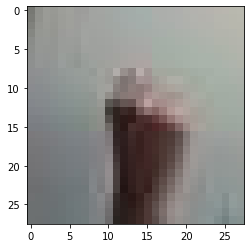

예측확률분포: [0. 0. 1.]
라벨: 1, 예측결과: 2


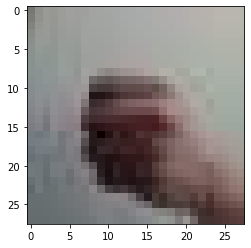

예측확률분포: [0. 0. 1.]
라벨: 0, 예측결과: 2


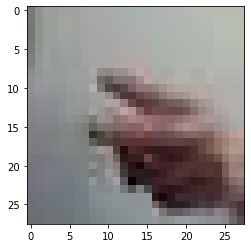

In [14]:
import random

wrong_predict_list=[]

for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test가 다른 경우만 모음
    if predicted_labels[i] != y_test[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)
    plt.show()

예측 결과가 형편 없다는 것을 확인할 수 있다.
그 이유를 분석해보면

- 학습데이터의 부족
- 학습데이터와 테스트 데이터가 서로 다른 환경에서 찍은 이미지이므로 배경, 조명, 자세 등이 다양하여 잘 정제된 데이터가 아님  
- 이미지 데이터의 크기 변경을 통한 테스트 부족(해상도에 따른 변화 확인 필요)
- 과대 적합을 방지할 수 있는 검증 세트 미적용

___


## 두번째 시도
첫 시도에서 분석한 내용을 토대로 개선사항을 적용하여 재 시도해 본다.

### 데이터 준비  
- 이미지 데이터 resize를 28x28 -> 112x112로 변경
- 더 많은 이미지 데이터 확보(이미지 총 5,656장)
- 과대 적합을 방지할 수 있는 검증 세트 적용 

성능 개선을 위해 위와 같은 변화를 시도해 보았다.

In [15]:
from PIL import Image
import os
import glob

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


### 이미지 사이즈 변경

In [16]:
def resize_images_new(img_path, h_size, v_size):
    
    images=glob.glob(img_path + "/*.jpg")  
    
    print(len(images), " images to be resized.")

    # 파일마다 모두 112x112 사이즈로 바꾸어 저장
    target_size=(h_size, v_size)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size,Image.ANTIALIAS)
        new_img.save(img, "JPEG")
    
    print(len(images), " images resized.")

`resize_image_new()` 함수로 이미지 size 변경

In [17]:
scissor_new_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_112x112_5656/scissor"  #가위 경로
rock_new_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_112x112_5656/rock"        #바위 경로
paper_new_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_112x112_5656/paper"      #보  경로

resize_images_new(scissor_new_image_dir_path, 112, 112)  # 가위 resize
print("가위 이미지 resize 완료!", '\n')
resize_images_new(rock_new_image_dir_path, 112, 112)     # 바위 resize
print("바위 이미지 resize 완료!", '\n')
resize_images_new(paper_new_image_dir_path, 112, 112)    # 보 resize
print("보 이미지 resize 완료!", '\n')


1859  images to be resized.
1859  images resized.
가위 이미지 resize 완료! 

1902  images to be resized.
1902  images resized.
바위 이미지 resize 완료! 

1895  images to be resized.
1895  images resized.
보 이미지 resize 완료! 



가위, 바위, 보 데이터를 불러오는 `load_data_new()` 함수를 만들어 사용하고  
x_train 학습데이터가 아닌 `x_data 전체데이터`로 만들자.  
라벨링은 이전과 동일하게 가위:0, 바위:1, 보:2 로 한다.

In [18]:
import numpy as np

def load_data_new(img_path, number_of_data=5656):  # 가위바위보 이미지 개수 총합에 주의
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size=112
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("전체데이터(x_data)의 이미지 개수는", idx,"입니다.")
    return imgs, labels


`load_data_new()` 함수로 가위, 바위, 보 이미지 전체데이터를 불러오자.

In [20]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_112x112_5656"
(x_data, y_data)=load_data_new(image_dir_path)

print("x_data shape: {}".format(x_data.shape))
print("y_data shape: {}".format(y_data.shape))


전체데이터(x_data)의 이미지 개수는 5656 입니다.
x_data shape: (5656, 112, 112, 3)
y_data shape: (5656,)


검증 데이터에 대해서 최적 성능을 보이는 하이퍼 파라미터를 선택한다.  
- 과대적합 방지를 위해 검증 데이터 포함
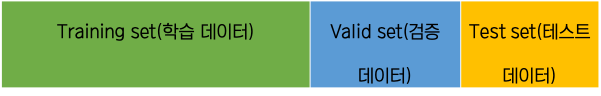  
        
    
    
    

이제 불러온 전체 데이터를 training, validation, test set 으로 나눠야한다.  


In [21]:
def train_val_test_split(ds, ds_size, sd, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정
        ds_shuffled = np.random.RandomState(seed=sd).permutation(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds_shuffled[0:train_size]    
    val_ds = ds_shuffled[train_size:train_size+val_size]
    test_ds = ds_shuffled[train_size+val_size:]
    
    return train_ds, val_ds, test_ds

In [22]:
x_train_new, x_val_new, x_test_new = train_val_test_split(x_data,5656,15)
y_train_new, y_val_new, y_test_new = train_val_test_split(y_data,5656,15)

trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정하였고 임의로 15 라는 값을 넣었다.  
세번째 인자인 sd(현재는 15) 값을 바꾸면 trainning set, validation set, test set 을 바꿔서 모델을 학습할 수 있다.


In [23]:
print(x_train_new.shape)
print(x_val_new.shape)
print(x_test_new.shape)

(4524, 112, 112, 3)
(565, 112, 112, 3)
(567, 112, 112, 3)


x_train_new, x_val_new, x_test_new 가 각각 4524개, 565개, 567개씩 나뉘었다.

In [24]:
print(y_train_new.shape)
print(y_val_new.shape)
print(y_test_new.shape)

(4524,)
(565,)
(567,)


y_train_new, y_val_new, y_test_new 또한 각각 4524개, 565개, 567개씩 나뉘었다.  
이미지 데이터와 라벨이 잘 들어갔는지 확인해보자.

라벨:  0


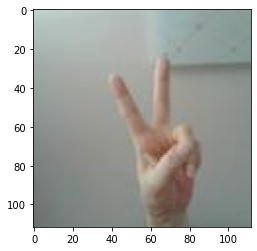

In [25]:
import matplotlib.pyplot as plt

plt.imshow(x_train_new[0])
print('라벨: ', y_train_new[0])

라벨:  2


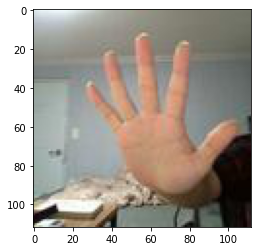

In [26]:
plt.imshow(x_val_new[0])
print('라벨: ', y_val_new[0])

라벨:  1


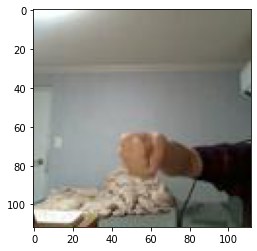

In [27]:
plt.imshow(x_test_new[0])
print('라벨: ', y_test_new[0])

데이터와 라벨이 올바르게 나누어진 것을 볼 수 있다.

### 딥러닝 네크워크 설계
처음 시도한 것과 동일하게 딥러닝 네트워크를 설계한다.

In [28]:
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)   # Tensorflow의 버전을 출력

2.5.0


In [44]:
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(112,112,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


In [45]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 110, 110, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 53, 53, 32)        4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 21632)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                692256    
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

### 모델 학습시키기  

모델을 학습 시키기 전에 x_train_new, x_val_new 데이터를 0~1 사이의 값으로 정규화 시켰다.

In [46]:
x_train_new_norm = x_train_new / 255.0

In [47]:
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_new_norm, y_train_new, epochs=10)

Epoch 1/10
  3/142 [..............................] - ETA: 4s - loss: 1.5769 - accuracy: 0.3021 

2022-01-09 18:42:27.984410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 3s 17ms/step - loss: 0.8723 - accuracy: 0.5694
Epoch 2/10
142/142 [==============================] - 2s 17ms/step - loss: 0.3997 - accuracy: 0.8464
Epoch 3/10
142/142 [==============================] - 2s 16ms/step - loss: 0.2246 - accuracy: 0.9275
Epoch 4/10
142/142 [==============================] - 2s 17ms/step - loss: 0.1324 - accuracy: 0.9629
Epoch 5/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0827 - accuracy: 0.9803
Epoch 6/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0477 - accuracy: 0.9903
Epoch 7/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0345 - accuracy: 0.9934
Epoch 8/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0204 - accuracy: 0.9951
Epoch 9/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0110 - accuracy: 0.9982
Epoch 10/10
142/142 [==============================] - 2s 17ms/step - loss: 0.0074 - accuracy: 0.9980


### Validation set을 이용한 모델 성능 평가  
Validation set을 이용한 모델 성능 평가를 실행하여 train set에 대한 과적합(overfitting) 문제를 막고,  
여러 하이퍼파라미터에 대해 조정할 수 있다.

지금의 경우는 간단하게 epochs 값만 조정해보자.

In [48]:
test_loss, test_accuracy = model.evaluate(x_val_new, y_val_new, verbose = 2)

print("test_loss : {}".format(test_loss))
print("test_accuracy : {}".format(test_accuracy))

2022-01-09 18:42:55.832804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


18/18 - 0s - loss: 16.2347 - accuracy: 0.9805
test_loss : 16.2347469329834
test_accuracy : 0.9805309772491455


- training set 으로 epochs 값이 7 일때, validation set 성능평가 결과 0.974
- **training set 으로 epochs 값이 10 일때, validation set 성능평가 결과 0.981**
- training set 으로 epochs 값이 12 일때, validation set 성능평가 결과 0.979  

여러번 epochs 값을 조정하며 각각의 validation set에서의 성능을 볼 수 있었다.  
그 결과 최적의 epochs 값을 찾아낼 수 있었지만 성능의 차이는 미미하였다.

### Test set을 이용한 최종 모델 성능 평가  


In [49]:
test_loss, test_accuracy = model.evaluate(x_test_new, y_test_new, verbose = 2)

print("최종 test_loss : {}".format(test_loss))
print("최종 test_accuracy : {}".format(test_accuracy))


18/18 - 0s - loss: 12.8610 - accuracy: 0.9788
최종 test_loss : 12.8610258102417
최종 test_accuracy : 0.9788359999656677


#### 최종적으로 모델의 성능은 97.9% 의 정확도를 보인다.  

마지막으로 test set에서 어떤 데이터를 잘못 예측했는지 확인해보자.

예측확률분포: [1. 0. 0.]
라벨: 2, 예측결과: 0


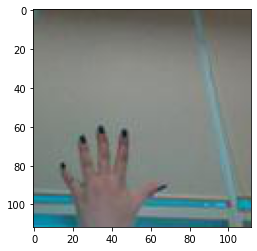

예측확률분포: [0. 1. 0.]
라벨: 0, 예측결과: 1


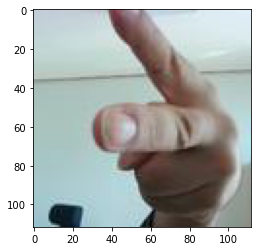

예측확률분포: [1. 0. 0.]
라벨: 2, 예측결과: 0


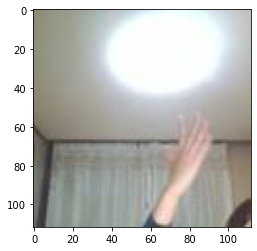

예측확률분포: [0. 0. 1.]
라벨: 0, 예측결과: 2


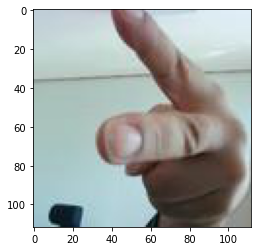

예측확률분포: [1. 0. 0.]
라벨: 2, 예측결과: 0


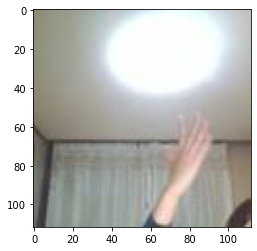

In [52]:
predicted_result = model.predict(x_test_new)  
predicted_labels = np.argmax(predicted_result, axis=1)

import random
wrong_predict_list=[]
for i, _ in enumerate(predicted_labels):
    # i번째 test_labels과 y_test이 다른 경우만 모음
    if predicted_labels[i] != y_test_new[i]:
        wrong_predict_list.append(i)

# wrong_predict_list 에서 랜덤하게 5개만 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

for n in samples:
    print("예측확률분포: " + str(predicted_result[n]))
    print("라벨: " + str(y_test_new[n]) + ", 예측결과: " + str(predicted_labels[n]))
    plt.imshow(x_test_new[n], cmap=plt.cm.binary)
    plt.show()

각도가 다른 이미지도 있지만 전체적으로 눈으로 봐서는 쉽게 구별이 가능한 이미지들을 잘못 예측했다.  
다수의 잘못 예측한 경우를 분석해 보면,
- 보인데 가위로, 가위인데 보로 잘못 예측하는 경우 :  보의 손가락이 벌어지고 안벌어지고의 모양에 따라 혼동하는 것으로 보임.
- 보인데 바위로 잘못 예측하는 경우 : 보의 손가락이 붙어있는 경우를 바위로 혼동하는 것으로 보임.

이미지의 잘 정리된 정도에 따라 정확도가 향상될 것으로 판단된다.


### 프로젝트 정리  

간단한 딥러닝 네트워크를 통해 가위, 바위 보를 분류하는 모델을 만들보았다.

`첫 시도에는 내가 찍은 가위, 바위, 보 사진 300장을 training set 으로 사용하여 모델을 학습.`  
`이후 다른 사람이 찍은 가위, 바위, 보 사진 150장을 test set 으로 사용하여 모델의 성능을 평가.`

그 결과 모델의 정확도는 ***33.3%*** 가 나왔다. 일반적으로 나올 수 있는 확률이므로 의미 없는 모델을 만들었던 것이다.  
그러한 결과가 나온 **원인 분석**은 다음과 같았다.

>- 학습데이터의 부족
>- 학습데이터와 테스트 데이터가 서로 다른 환경에서 찍은 이미지이므로 배경, 조명, 자세 등이 다양하여 잘 정제된 데이터가 아님  
>- 이미지 데이터의 크기 변경을 통한 테스트 부족(해상도에 따른 변화 확인 필요)
>- 과대 적합을 방지할 수 있는 검증 세트 미적용

원인 분석을 바탕으로 문제의 **해결책**은 다음과 같다.

>- 이미지 데이터 resize를 28x28 -> 112x112로 변경
>- 더 많은 이미지 데이터 확보(학습:300장, 테스트:150장 -> 총 5,656장)
>- 과대 적합을 방지할 수 있는 검증 세트 적용 

그 결과 **98.1%** 의 정확도를 가지는 모델을 만들어낼수 있었다.

여기서 더 높은 성능의 모델을 만들고 싶다면

>- 더 많고 다양한 데이터들을 수집
>- 잘 정제되어 있을 것
>- 적절한 hyperparameter, hidden layer 결정
>- 과적합을 막기위한 dropout 적용

등의 방법으로 모델을 개선 시킬 수 있을 것이라고 생각한다.